In [1]:
%run __init__.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from itertools import combinations
from aper_phot import *
from cr2others import *

In [2]:
def generate_src_reg(src_reg_name, 
                     r_low, r_up, r_step, 
                     d_low, d_up, d_step, 
                     dire_1, dire_2):
    # generate radiu list (array)
    radiu_list = np.linspace(r_low, r_up, r_step).tolist()
    # generate centers
    # dire_1 = [448, 1210]; dire_2 = [990, 1810]
    dire_dist = get_dist(dire_1, dire_2)
    dire_i = abs(dire_1[1]-dire_2[1])/dire_dist
    dire_j = abs(dire_1[0]-dire_2[0])/dire_dist
    dist_list = np.linspace(d_low, d_up, d_step)
    center_nucleus = [1001, 1001]
    center_i = center_nucleus[1] + dist_list*dire_i
    center_j = center_nucleus[0] + dist_list*dire_j
    center_i = center_i.tolist()
    center_j = center_j.tolist()
    center_list = list(zip(center_j, center_i))
    # write into a file
    src_reg_path = get_path('../docs/'+src_reg_name)
    f = open(src_reg_path, 'w')
    f.write('# Generated regions for photometry of the source'+'\n')
    f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1'+'\n')
    f.write('physical'+'\n')
    for r in radiu_list:
        for c in center_list:
            f.write('circle(' + str(c[0]) + ',' + str(c[1]) + ',' + str(r)+') # color=black width=1' + '\n')
    f.close()

In [100]:
def src_snr(img_name, reg_name, bg_method, bg_center, bg_r):
    # bkg -> bg_bri, bg_bri_err
    bg_bri, bg_bri_err = reg2bg_bri(img_name, bg_method, bg_center, bg_r)
    # load regions
    center_i_list, center_j_list, radiu_list = load_reg_list(reg_name)
    # photometry -> snr
    dist_list = []
    count_list = []
    pixel_list = []
    cr_list = []
    snr_list = []
    exposure = float(load_header(img_name)['EXPTIME'])
    reg_num = len(radiu_list)
    for n in range(reg_num):
        center = [center_i_list[n], center_j_list[n]]
        count, pixel = circle_ct(img_name, center, radiu_list[n])
        src_count_err = np.sqrt(count)
        cr, cr_err, snr = aper_phot(count,
                                    pixel,
                                    bg_bri, exposure,
                                    src_count_err,
                                    bg_bri_err)
        dist_list.append(get_dist(center, (1001, 1001)))
        count_list.append(count)
        pixel_list.append(pixel)
        cr_list.append(cr)
        snr_list.append(snr)
    # plot snr-size, snr-dist
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(121)
    plt.plot(radiu_list, snr_list, 'ro')
    plt.xlabel('r')
    plt.ylabel('snr')
    ax2 = fig1.add_subplot(122)
    plt.plot(dist_list, snr_list, 'bo')
    plt.xlabel('distace to nucleus')
    plt.show()
    # plot 2D, ref: stack overflow: 48708862, 39727040
    fig2 = plt.figure()
    ax = fig2.add_subplot(111)
    radiu_list = np.array(radiu_list)
    dist_list = np.array(dist_list)
    snr_list = np.array(snr_list)
    plt.scatter(radiu_list, dist_list, c=snr_list, cmap='jet')
    for i, txt in enumerate(snr_list):
        ax.annotate(round(txt,1), (radiu_list[i], dist_list[i]+(np.mean(dist_list)-dist_list[i])*0.15), alpha=0.4, size=8)
    plt.xlabel('r')
    plt.ylabel('distance to nucleus')
    plt.colorbar()
    plt.show()

In [95]:
def bg_snr(method, img_name, reg_name, src_center, src_r):
    # source photometry
    exposure = float(load_header(img_name)['EXPTIME'])
    src_count, src_pixel = circle_ct(img_name, src_center, src_r)
    src_count_err = np.sqrt(src_count)
    # load regions
    center_i_list, center_j_list, radiu_list = load_reg_list(reg_name)
    center_list = list(zip(center_j_list, center_i_list))
    # photometry -> snr
    snr_list = []
    cr_list = []
    if method == 'single':
        img_center = (917, 1312)
        src2cen = get_dist(src_center, img_center)
        dist_dif_list = []
        dist2src_list = []
    for n in range(len(radiu_list)):
        bg_bri, bg_bri_err = reg2bg_bri(img_name, method, center_list[n], radiu_list[n])
        cr, cr_err, snr = aper_phot(src_count,
                                    src_pixel,
                                    bg_bri, exposure, 
                                    src_count_err,
                                    bg_bri_err)
        snr_list.append(snr)
        cr_list.append(snr)
        if method == 'single':
            dist_dif = abs(get_dist(center_list[n], img_center) - src2cen)
            dist_dif_list.append(dist_dif)
            dist2src = get_dist(center_list[n], src_center)
            dist2src_list.append(dist2src)
    if method == 'single':
        # plot snr-size
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(131)
        plt.plot(radiu_list, snr_list, 'ro')
        plt.xlabel('radiu')
        plt.ylabel('snr')
        ax2 = fig1.add_subplot(132)
        plt.plot(dist_dif_list, snr_list, 'bo')
        plt.xlabel(r'$|distance_{center} - distance_{source}|$')
        ax3 = fig1.add_subplot(133)
        plt.plot(dist2src_list, snr_list, 'go')
        plt.xlabel(r'$distance_{source}$')
        plt.show()
        fig2 = plt.figure()
        ax = fig2.add_subplot(111)
        dist_dif_list = np.array(dist_dif_list)
        dist2src_list = np.array(dist2src_list)
        radiu_list = np.array(radiu_list)
        snr_list = np.array(snr_list)
        plt.scatter(dist_dif_list, dist2src_list, s=radiu_list, c=snr_list, cmap='jet')
        plt.xlabel(r'$|distance_{center} - distance_{source}|$')
        plt.ylabel(r'$distance_{source}$')
        plt.colorbar()
        plt.show()
        # plot bubble map: 14827650; scatter temporal

In [153]:
def bg_multi_circle_snr(img_name, reg_name, src_center, src_r, n):
    # source photometry
    exposure = float(load_header(img_name)['EXPTIME'])
    src_count, src_pixel = circle_ct(img_name, src_center, src_r)
    src_count_err = np.sqrt(src_count)
    # load regions to lists of x, y and r
    center_i_list, center_j_list, radiu_list = load_reg_list(reg_name)
    radiu_set = set(radiu_list)
    # convert 3 lists to dataframe
    bg_reg = {'x': center_j_list,
              'y': center_i_list,
              'r': radiu_list}
    bg_reg = pd.DataFrame(bg_reg)
    # loop for every r and n locations, note: check Exception
    cr_list = []
    snr_list = []
    size_list = []
    distribution_list = []
    distance_list = []
    for r in radiu_set:
        center_df = bg_reg[bg_reg['r']==r]
        if len(center_df) < n:
            raise Exception('number of bg regions is less than n for radiu-'+str(r))
        center_x = list(center_df['x'])
        center_y = list(center_df['y'])
        center_for_r = list(zip(center_x, center_y))
        center_group = combinations(center_for_r, n)
        # get the distribution value and distances to the source
        for center_list in center_group:
            r_list = [r for k in range(n)]
            # photometry
            count_list, pixel_list = multi_circle_ct(img_name, center_list, r_list)
            bg_bri, bg_bri_err = reg2bg_bri(img_name, 'multi', center_list, r_list, n)
            cr, cr_err, snr = aper_phot(src_count, src_pixel, bg_bri, exposure, src_count_err, bg_bri_err)
            # output - cr, snr, size
            cr_list.append(cr)
            snr_list.append(snr)
            size_list.append(sum(pixel_list))
            # output - distribution
            distribution = 0
            for line in combinations(center_list, 2):
                distribution += get_dist(line[0], line[1])
            distribution = distribution/len(list(combinations(center_list, 2)))
            distribution_list.append(distribution)
            # output - mean distance
            dist = 0
            for center in center_list:
                dist += get_dist(center, src_center)
            dist = dist/len(center_list)
            distance_list.append(dist)
    # plot snr-size
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(131)
    plt.plot(size_list, snr_list, 'ro')
    plt.xlabel('total pixel')
    plt.ylabel('snr')
    ax2 = fig1.add_subplot(132)
    plt.plot(distribution_list, snr_list, 'bo')
    plt.xlabel('mean of '+r'$distances(bg_a-bg_b)$')
    ax3 = fig1.add_subplot(133)
    plt.plot(distance_list, snr_list, 'go')
    plt.xlabel('mean of '+r'$distance_{source}$')
    plt.show()
    fig2 = plt.figure()
    ax = fig2.add_subplot(111)
    distribution_list = np.array(distribution_list)
    distance_list = np.array(distance_list)
    size_list = np.array(size_list)
    snr_list = np.array(snr_list)
    plt.scatter(distribution_list, distance_list, s=size_list/300., c=snr_list, cmap='jet')
    plt.xlabel('mean of '+r'$distances(bg_a-bg_b)$')
    plt.ylabel('mean of '+r'$distance_{source}$')
    plt.colorbar()
    plt.show()

# UW1 Filter

## search for the optimum region of source

In [137]:
generate_src_reg('src_regs.reg', 
                 r_low = 8, r_up = 19, r_step = 12, 
                 d_low = 0, d_up = 4, d_step = 5,
                 dire_1=[448,1210], dire_2=[990,1810])

<div align="center">
<img src="https://i.loli.net/2019/11/08/MtLW96ZJjnEY4iU.jpg" width="300">
<div/>

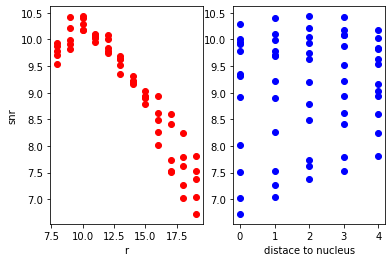

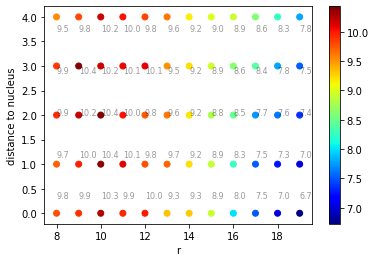

In [101]:
center_list = [(1088.8611, 1040.0833), 
               (1194.8611, 1135.0833), 
               (846.8611, 976.0833)]
r_list = [20.86768, 20.86768, 20.86768]
src_snr(img_name = 'stacked_img_uw1.fits',
        reg_name = 'src_regs.reg',
        bg_method = 'multi',
        bg_center = center_list,
        bg_r = r_list)

<div align="center">
<img src="https://i.loli.net/2019/11/08/zI8U7kDOvdlSwgm.jpg" width="200"/><img src="https://i.loli.net/2019/11/08/FO4E5hL1jliD6pH.jpg" width="300"/>
</div>

## search for the optimum reg of bg: single

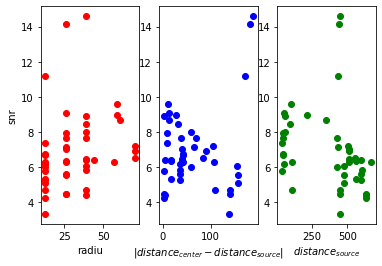

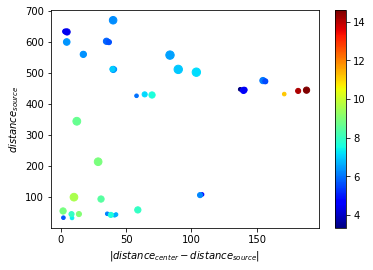

In [99]:
src_center = (1002.3406603987888,1002.4841259027182)
src_r = 13.0
bg_snr(method='single',
       img_name = 'stacked_img_uw1.fits',
       reg_name = 'bg_single_uw1.reg',
       src_center = src_center, 
       src_r = src_r)

background regions of 'a single region' method
<img src="https://i.loli.net/2019/11/08/KUvba4P6pRjXTkt.jpg">

## search for the optimum reg of bg: multi

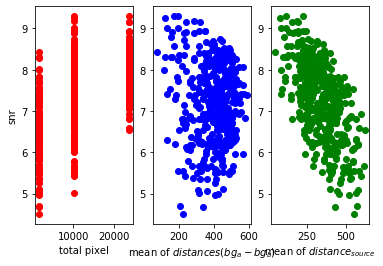

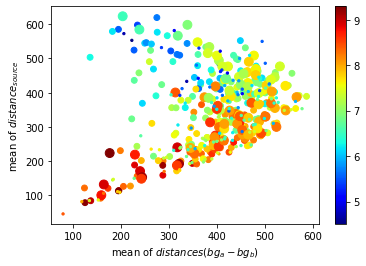

In [155]:
# ((1078.312, 1047.9472), (867.49601, 970.18721), (964.26401, 1066.9552))
src_center = (1002.3406603987888,1002.4841259027182)
src_r = 13.0
bg_multi_circle_snr(img_name='stacked_img_uw1.fits', 
                    reg_name='bg_multi_uw1.reg', 
                    src_center=src_center, 
                    src_r=src_r, n=3)

background regions of 'multiple regions' method
<img src="https://i.loli.net/2019/11/08/ld1Q4Pu8etbxCLc.jpg">

# V Filter

## search for the optimum region of source

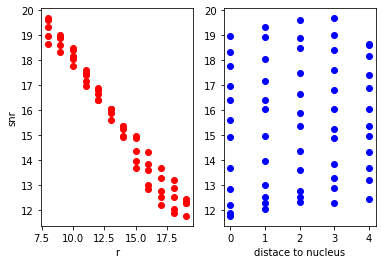

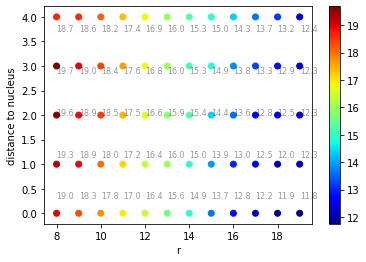

In [139]:
center_list = [(1088.8611, 1040.0833), 
               (1194.8611, 1135.0833), 
               (846.8611, 976.0833)]
r_list = [20.86768, 20.86768, 20.86768]
src_snr(img_name = 'stacked_img_uvv.fits',
        reg_name = 'src_regs.reg',
        bg_method = 'multi',
        bg_center = center_list,
        bg_r = r_list)

<div align="center">
<img src="https://i.loli.net/2019/11/08/x9oj1pQCrSwuniO.jpg" width="300">
<div/>

## search for the optimum reg of bg: single

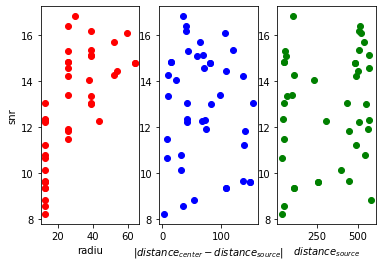

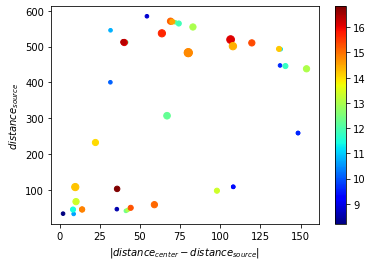

In [140]:
src_center = (1002.3406603987888,1002.4841259027182)
src_r = 15.0
bg_snr(method='single',
       img_name = 'stacked_img_uvv.fits',
       reg_name = 'bg_single_uvv.reg',
       src_center = src_center, 
       src_r = src_r)

## search for the optimum reg of bg: multi

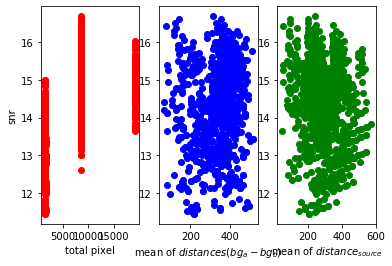

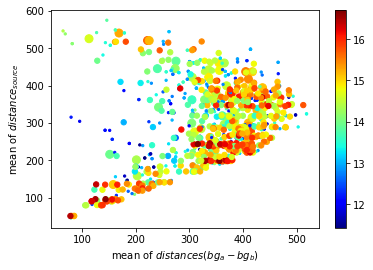

In [154]:
# ((1053.4288, 1009.2016), (1007.656, 952.32321), (952.69199, 985.3512))
src_center = (1002.3406603987888,1002.4841259027182)
src_r = 15.0
bg_multi_circle_snr(img_name='stacked_img_uvv.fits', 
                    reg_name='bg_multi_uvv.reg', 
                    src_center=src_center, 
                    src_r=src_r, n=3)

background regions of 'multiple regions' method
<img src="https://i.loli.net/2019/11/08/1rt7uqvWlmX8fPS.jpg">

# aperture photometry

In [4]:
# for uw1
img_name_uw1 = 'stacked_img_uw1.fits'
src_center_uw1 = (1002.3406603987888,1002.4841259027182)
src_r_uw1 = 13.0
bg_center_uw1 = [(1078.312, 1047.9472), (867.49601, 970.18721), (964.26401, 1066.9552)]
bg_r_uw1 = [50, 50, 50]
cr_uw1, snr_uw1, mag_uw1 = aper_phot_multi(img_name_uw1, 'uw1', src_center_uw1, src_r_uw1, bg_center_uw1, bg_r_uw1)

# for v
img_name_uvv = 'stacked_img_uvv.fits'
src_center_uvv = (1002.3406603987888,1002.4841259027182)
src_r_uvv = 15.0
bg_center_uvv = [(1053.4288, 1009.2016), (1007.656, 952.32321), (952.69199, 985.3512)]
bg_r_uvv = [30, 30, 30]
cr_uvv, snr_uvv, mag_uvv = aper_phot_multi(img_name_uvv, 'v', src_center_uvv, src_r_uvv, bg_center_uvv, bg_r_uvv)

# print
print('for UW1:')
print('count rate: '+str(cr_uw1)+';  SNR: '+str(snr_uw1)+';  mag: '+str(mag_uw1))

print('for V:')
print('count rate: '+str(cr_uvv)+';  SNR: '+str(snr_uvv)+';  mag: '+str(mag_uvv))

for UW1:
count rate: 0.16002345185905942;  SNR: 8.787639760675761;  mag: 19.4795409141942
for V:
count rate: 1.7676817492487165;  SNR: 15.386746512865122;  mag: 17.271489805018856
